In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
# transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = datasets.FashionMNIST('./data', download=True, train=True, transform=transform)
train_loader = DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('./data', download=True, train=False, transform=transform)
test_loader = DataLoader(testset, batch_size=10000, shuffle=True)

# Download and load the OOD data
oodset = datasets.MNIST('./data', download=True, train=False, transform=transform)
ood_loader = DataLoader(oodset, batch_size=10000, shuffle=True)

In [3]:
print(trainset)
print(testset)
print(oodset)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


In [4]:
class ConvolutionalAutoencoder(nn.Module):
    def __init__(self):
        super(ConvolutionalAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 10, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(10, 64, 7),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 16, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        
    def encode(self,x):
        return self.encoder(x)
    
    def decode(self,x):
        return self.decoder(x)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [5]:
# creating model,and defining optimizer and loss
model = ConvolutionalAutoencoder()
# moving model to gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)
model.to(device)
print(model)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.MSELoss()

We're using => cuda:0
ConvolutionalAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 10, kernel_size=(7, 7), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(10, 64, kernel_size=(7, 7), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(64, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_paddi

In [6]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

Pullover
torch.Size([64, 1, 28, 28]) torch.Size([64])


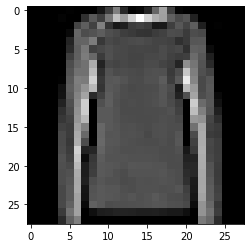

In [7]:
image, label = next(iter(train_loader))
plt.imshow(image[10].squeeze(), cmap="gray")
print(output_label(label[10]))
print(image.size(), label.size())

In [8]:
clr_map = {
    0:"blue",
    1:"orange",
    2:"red",
    3:"brown",
    4:"cyan",
    5:"green",
    6:"olive",
    7:"pink",
    8:"purple",
    9:"gray",
    }

In [9]:
def Accuracy(y_pred, y_test):
    _, y_pred_tags = torch.max(y_pred, dim = 1)
    correct_results_sum = (y_pred_tags == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc

In [10]:
print("Begin training.")
for e in tqdm(range(20)):
    # TRAINING
    train_epoch_loss = 0
    #train_epoch_acc = 0
    batch_num = 1
    model.train()
    for X_train_batch, y_train_batch in tqdm(train_loader):
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        #X_train_batch = X_train_batch.view(X_train_batch.size(0), -1)
        y_train_pred = model(X_train_batch)
        train_loss = criterion(y_train_pred, X_train_batch)
        #train_acc = Accuracy(y_train_pred, y_train_batch)
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()
        #train_epoch_acc += train_acc.item()
        #print(f'{batch_num+0:02}: | Train Acc: {train_acc} | Train Loss: {train_loss.item()}')
        batch_num += 1
    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f}')

Begin training.



Epoch 00: | Train Loss: 0.64909



Epoch 01: | Train Loss: 0.59761



Epoch 02: | Train Loss: 0.59430



Epoch 03: | Train Loss: 0.59294



Epoch 04: | Train Loss: 0.59217



Epoch 05: | Train Loss: 0.59164



Epoch 06: | Train Loss: 0.59125



Epoch 07: | Train Loss: 0.59095



Epoch 08: | Train Loss: 0.59073



Epoch 09: | Train Loss: 0.59055



Epoch 10: | Train Loss: 0.59038



Epoch 11: | Train Loss: 0.59029



Epoch 12: | Train Loss: 0.59017



Epoch 13: | Train Loss: 0.59009



Epoch 14: | Train Loss: 0.59004



Epoch 15: | Train Loss: 0.58996



Epoch 16: | Train Loss: 0.58995



Epoch 17: | Train Loss: 0.58986



Epoch 18: | Train Loss: 0.58983



Epoch 19: | Train Loss: 0.58979



tensor([[1.0286]], device='cuda:0')
torch.Size([10000, 10])
tensor(1.0286, device='cuda:0')



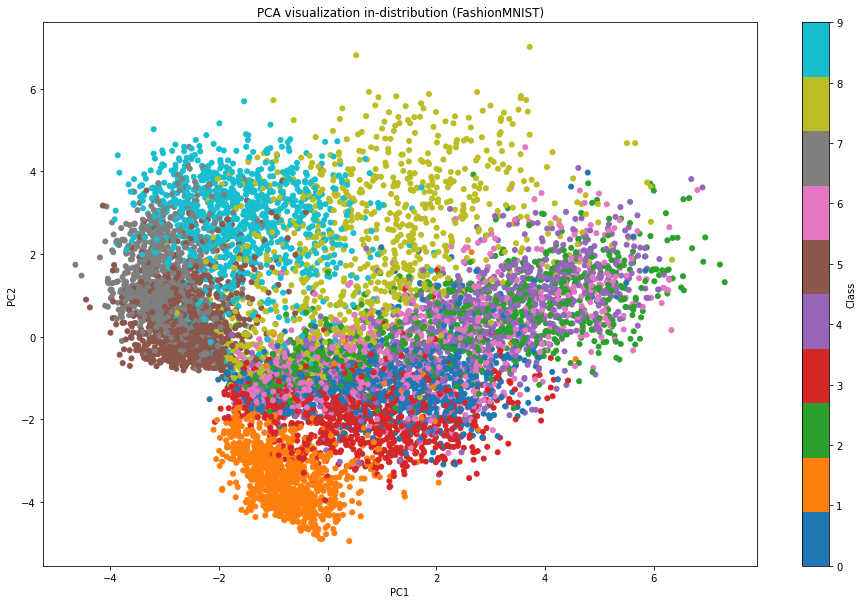

In [11]:
#TESTING PCA visualization in-distribution
plt.figure(figsize=(16,10))
plt.title("PCA visualization in-distribution (FashionMNIST)")
plt.xlabel("PC1")
plt.ylabel("PC2")
marker_size=25

pca = PCA(n_components=2)
model.eval()
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        #x_batch = x_batch.view(x_batch.size(0), -1)
        y_test_pred = model.encode(x_batch)
        print(y_test_pred[0][0])
        y_test_pred = y_test_pred.squeeze()
        print(y_test_pred.shape)
        print(y_test_pred[0][0])
        pca_result = pca.fit_transform(y_test_pred.cpu().detach().numpy())
        plt.scatter(pca_result[:,0], pca_result[:,1], marker_size, c=y_batch.cpu(), cmap='tab10')
cbar = plt.colorbar()
cbar.set_label("Class")
plt.show()

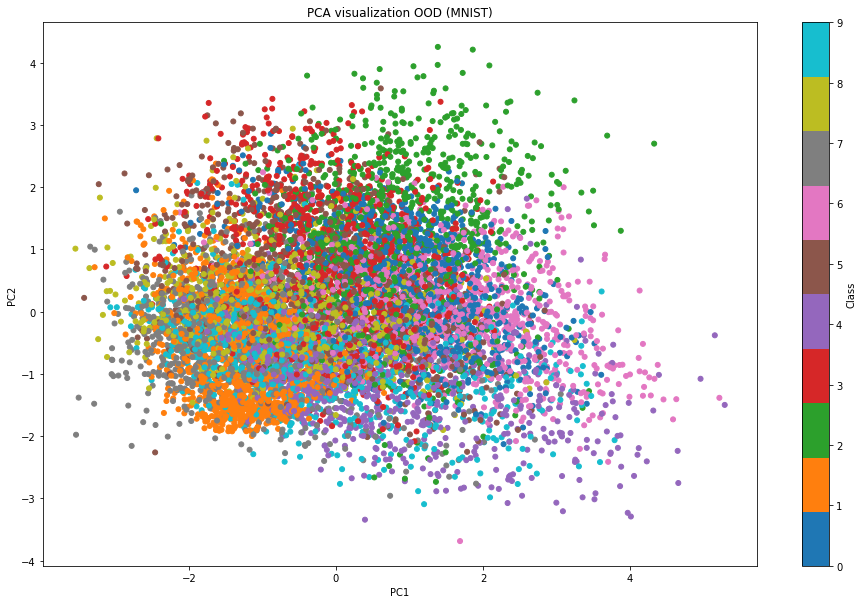

In [12]:
#TESTING PCA visualization out-distribution
plt.figure(figsize=(16,10))
plt.title("PCA visualization OOD (MNIST)")
plt.xlabel("PC1")
plt.ylabel("PC2")
marker_size=25

pca = PCA(n_components=2)
model.eval()
with torch.no_grad():
    for x_batch, y_batch in tqdm(ood_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        #x_batch = x_batch.view(x_batch.size(0), -1)
        y_test_pred = model.encode(x_batch)
        y_test_pred = y_test_pred.squeeze()
        pca_result = pca.fit_transform(y_test_pred.cpu().detach().numpy())
        plt.scatter(pca_result[:,0], pca_result[:,1], marker_size, c=y_batch.cpu(), cmap='tab10')
cbar = plt.colorbar()
cbar.set_label("Class")
plt.show()

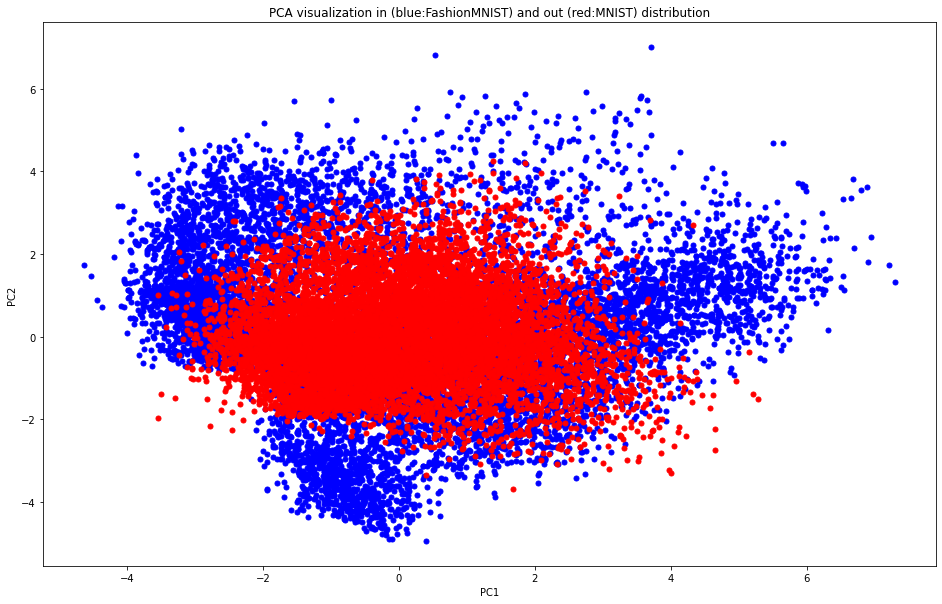

In [13]:
#TESTING PCA visualization in and out distribution together
plt.figure(figsize=(16,10))
plt.title("PCA visualization in (blue:FashionMNIST) and out (red:MNIST) distribution")
plt.xlabel("PC1")
plt.ylabel("PC2")
marker_size=25


model.eval()
with torch.no_grad():
    #in-distribution data plotting
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        #x_batch = x_batch.view(x_batch.size(0), -1)
        y_test_pred = model.encode(x_batch)
        y_test_pred = y_test_pred.squeeze()
        pca_result = PCA(n_components=2).fit_transform(y_test_pred.cpu().detach().numpy())
        plt.scatter(pca_result[:,0], pca_result[:,1], marker_size, c='b')
    
    #out-distribution data plotting    
    for x_batch, y_batch in tqdm(ood_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        #x_batch = x_batch.view(x_batch.size(0), -1)
        y_test_pred = model.encode(x_batch)
        y_test_pred = y_test_pred.squeeze()
        pca_result = PCA(n_components=2).fit_transform(y_test_pred.cpu().detach().numpy())
        plt.scatter(pca_result[:,0], pca_result[:,1], marker_size, c='r')
plt.show()

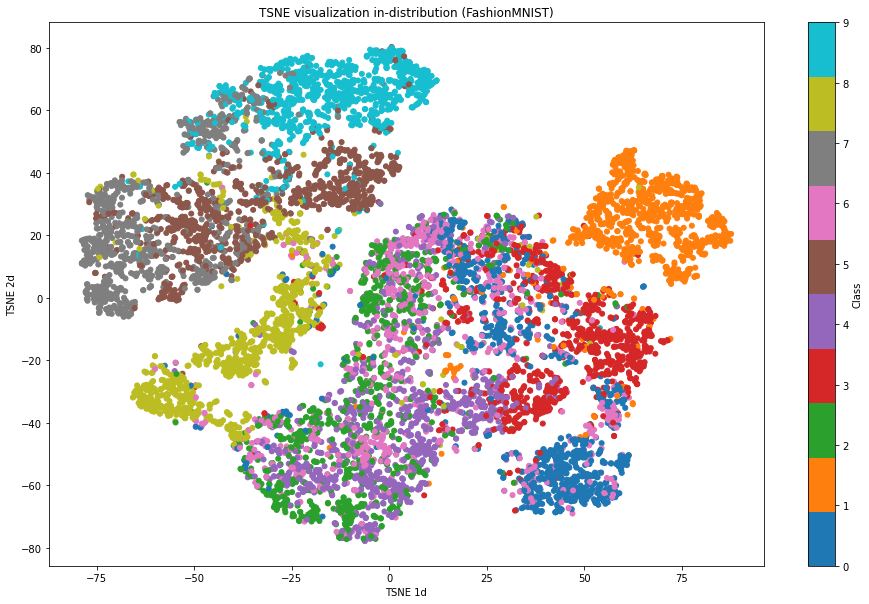

In [14]:
#TESTING TSNE visualization in-distribution
plt.figure(figsize=(16,10))
plt.title("TSNE visualization in-distribution (FashionMNIST)")
plt.xlabel("TSNE 1d")
plt.ylabel("TSNE 2d")
marker_size=25

tsne = TSNE(n_components=2)
model.eval()
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        #x_batch = x_batch.view(x_batch.size(0), -1)
        y_test_pred = model.encode(x_batch)
        y_test_pred = y_test_pred.squeeze()
        tsne_result = tsne.fit_transform(y_test_pred.cpu().detach().numpy())
        plt.scatter(tsne_result[:,0], tsne_result[:,1], marker_size, c=y_batch.cpu(), cmap='tab10')
cbar = plt.colorbar()
cbar.set_label("Class")
plt.show()

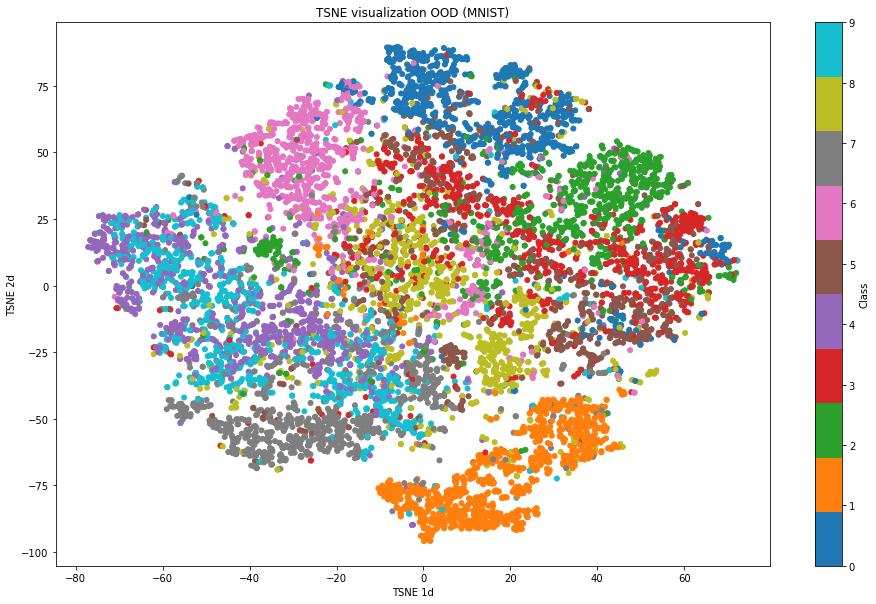

In [15]:
#TESTING TSNE visualization out-distribution
plt.figure(figsize=(16,10))
plt.title("TSNE visualization OOD (MNIST)")
plt.xlabel("TSNE 1d")
plt.ylabel("TSNE 2d")
marker_size=25

tsne = TSNE(n_components=2)
model.eval()
with torch.no_grad():
    for x_batch, y_batch in tqdm(ood_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        #x_batch = x_batch.view(x_batch.size(0), -1)
        y_test_pred = model.encode(x_batch)
        y_test_pred = y_test_pred.squeeze()
        tsne_result = tsne.fit_transform(y_test_pred.cpu().detach().numpy())
        plt.scatter(tsne_result[:,0], tsne_result[:,1], marker_size, c=y_batch.cpu(), cmap='tab10')
cbar = plt.colorbar()
cbar.set_label("Class")
plt.show()

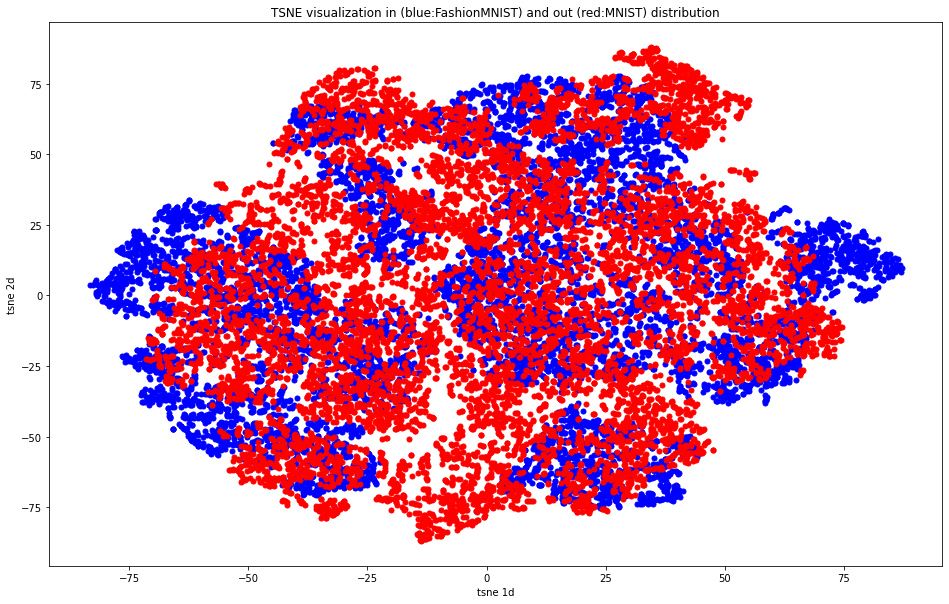

In [16]:
#TESTING TSNE visualization in and out distribution together
plt.figure(figsize=(16,10))
plt.title("TSNE visualization in (blue:FashionMNIST) and out (red:MNIST) distribution")
plt.xlabel("tsne 1d")
plt.ylabel("tsne 2d")
marker_size=25


model.eval()
with torch.no_grad():
    #in-distribution data plotting
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        #x_batch = x_batch.view(x_batch.size(0), -1)
        y_test_pred = model.encode(x_batch)
        y_test_pred = y_test_pred.squeeze()
        tsne_result = TSNE(n_components=2).fit_transform(y_test_pred.cpu().detach().numpy())
        plt.scatter(tsne_result[:,0], tsne_result[:,1], marker_size, c='b')
    
    #out-distribution data plotting
    for x_batch, y_batch in tqdm(ood_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        #x_batch = x_batch.view(x_batch.size(0), -1)
        y_test_pred = model.encode(x_batch)
        y_test_pred = y_test_pred.squeeze()
        tsne_result = TSNE(n_components=2).fit_transform(y_test_pred.cpu().detach().numpy())
        plt.scatter(tsne_result[:,0], tsne_result[:,1], marker_size, c='r')
plt.show()

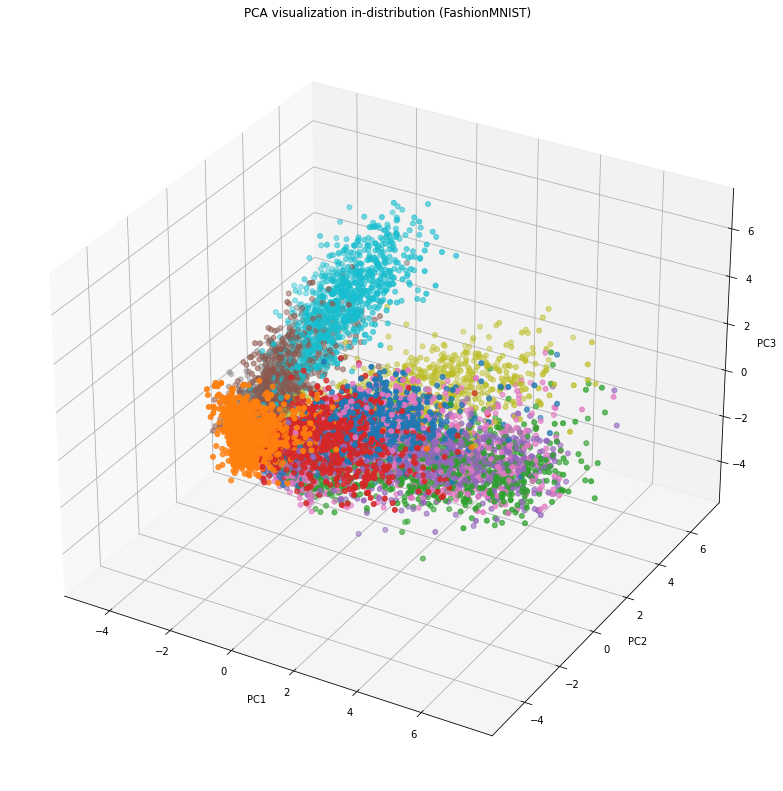

In [17]:
#TESTING PCA visualization in-distribution in 3D
plt.figure(figsize=(16,14))
ax = plt.axes(projection='3d')
ax.set_title("PCA visualization in-distribution (FashionMNIST)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
marker_size=25

pca = PCA(n_components=3)
model.eval()
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        #x_batch = x_batch.view(x_batch.size(0), -1)
        y_test_pred = model.encode(x_batch)
        y_test_pred = y_test_pred.squeeze()
        pca_result = pca.fit_transform(y_test_pred.cpu().detach().numpy())
        ax.scatter(pca_result[:,0], pca_result[:,1], pca_result[:,2], s=marker_size, c=y_batch.cpu(), cmap='tab10')
#cbar = plt.colorbar()
cbar.set_label("Class")
plt.show()

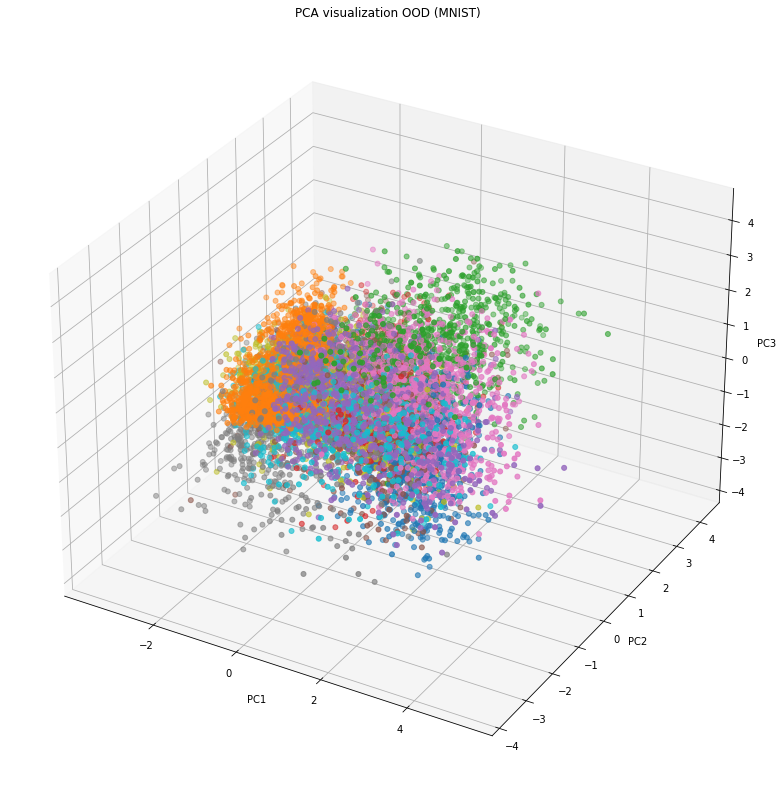

In [18]:
#TESTING PCA visualization out-distribution in 3D
plt.figure(figsize=(16,14))
ax = plt.axes(projection='3d')
ax.set_title("PCA visualization OOD (MNIST)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
marker_size=25

pca = PCA(n_components=3)
model.eval()
with torch.no_grad():
    for x_batch, y_batch in tqdm(ood_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        #x_batch = x_batch.view(x_batch.size(0), -1)
        y_test_pred = model.encode(x_batch)
        y_test_pred = y_test_pred.squeeze()
        pca_result = pca.fit_transform(y_test_pred.cpu().detach().numpy())
        ax.scatter(pca_result[:,0], pca_result[:,1], pca_result[:,2], s=marker_size, c=y_batch.cpu(), cmap='tab10')
#cbar = plt.colorbar()
cbar.set_label("Class")
plt.show()

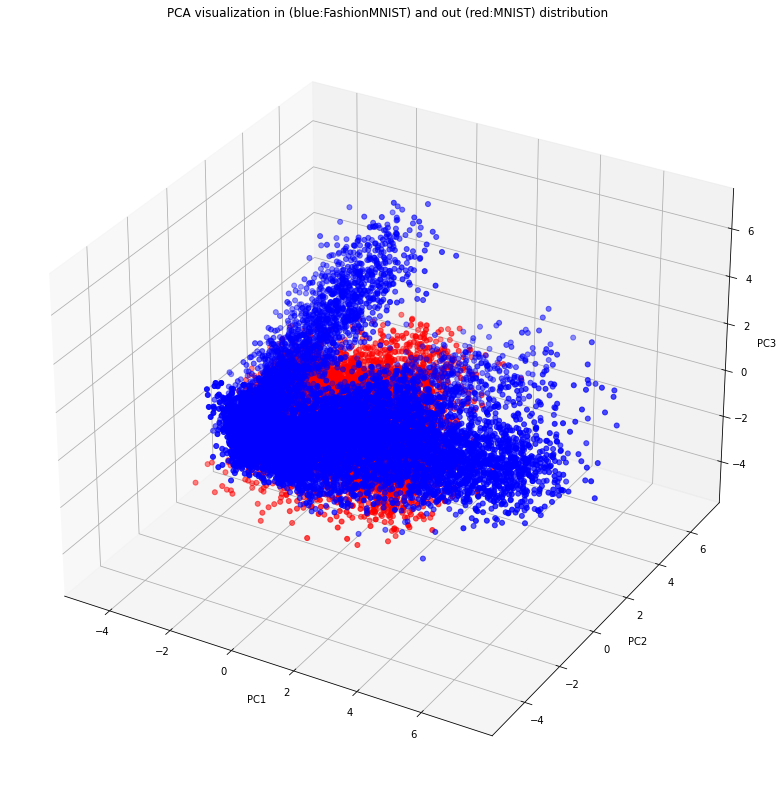

In [19]:
#TESTING PCA visualization in and out distribution together in 3D
plt.figure(figsize=(16,14))
ax = plt.axes(projection='3d')
ax.set_title("PCA visualization in (blue:FashionMNIST) and out (red:MNIST) distribution")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
marker_size=25


model.eval()
with torch.no_grad():
    #in-distribution data plotting
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        #x_batch = x_batch.view(x_batch.size(0), -1)
        y_test_pred = model.encode(x_batch)
        y_test_pred = y_test_pred.squeeze()
        pca_result = PCA(n_components=3).fit_transform(y_test_pred.cpu().detach().numpy())
        ax.scatter(pca_result[:,0], pca_result[:,1], pca_result[:,2], s=marker_size, c='b')
    
    #out-distribution data plotting    
    for x_batch, y_batch in tqdm(ood_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        #x_batch = x_batch.view(x_batch.size(0), -1)
        y_test_pred = model.encode(x_batch)
        y_test_pred = y_test_pred.squeeze()
        pca_result = PCA(n_components=3).fit_transform(y_test_pred.cpu().detach().numpy())
        ax.scatter(pca_result[:,0], pca_result[:,1], pca_result[:,2], s=marker_size, c='r')
plt.show()

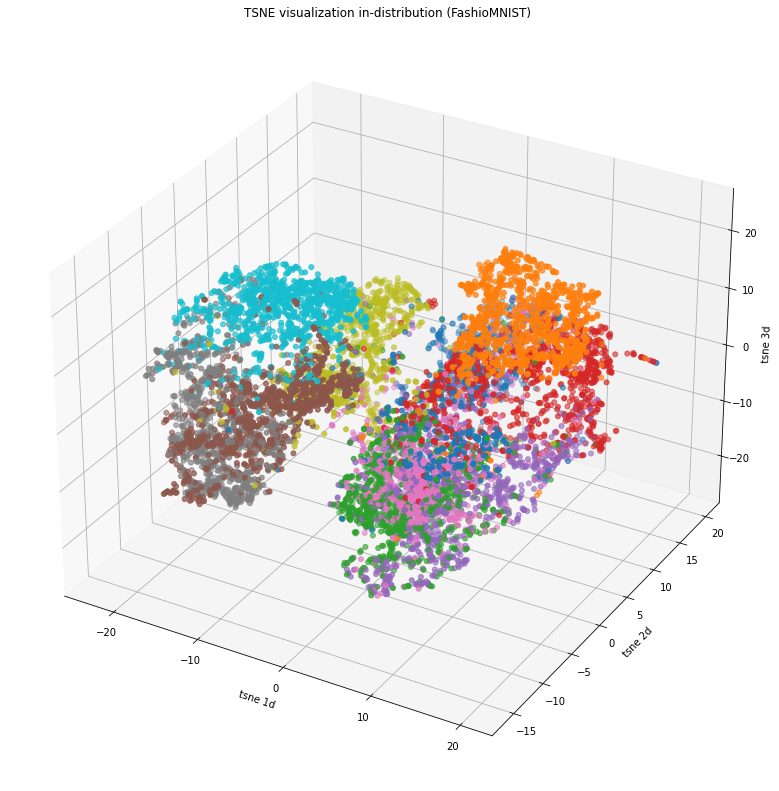

In [20]:
#TESTING TSNE visualization in-distribution in 3D
plt.figure(figsize=(16,14))
ax = plt.axes(projection='3d')
ax.set_title("TSNE visualization in-distribution (FashioMNIST)")
ax.set_xlabel("tsne 1d")
ax.set_ylabel("tsne 2d")
ax.set_zlabel("tsne 3d")
marker_size=25

tsne = TSNE(n_components=3)
model.eval()
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        #x_batch = x_batch.view(x_batch.size(0), -1)
        y_test_pred = model.encode(x_batch)
        y_test_pred = y_test_pred.squeeze()
        tsne_result = tsne.fit_transform(y_test_pred.cpu().detach().numpy())
        ax.scatter(tsne_result[:,0], tsne_result[:,1], tsne_result[:,2], s=marker_size, c=y_batch.cpu(), cmap='tab10')
#cbar = plt.colorbar()
cbar.set_label("Class")
plt.show()

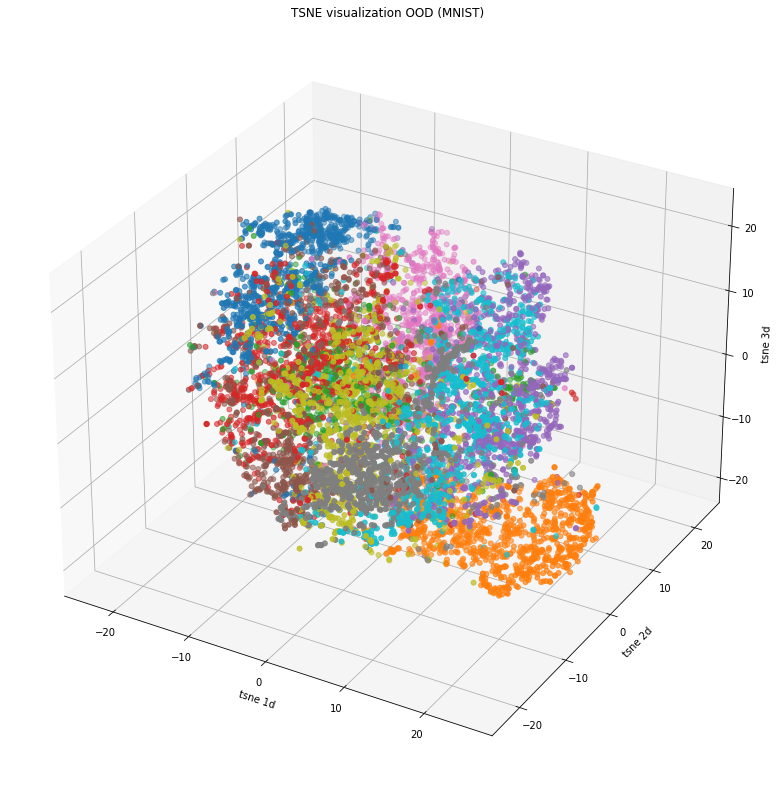

In [21]:
#TESTING TSNE visualization out-distribution in 3D
plt.figure(figsize=(16,14))
ax = plt.axes(projection='3d')
ax.set_title("TSNE visualization OOD (MNIST)")
ax.set_xlabel("tsne 1d")
ax.set_ylabel("tsne 2d")
ax.set_zlabel("tsne 3d")
marker_size=25

tsne = TSNE(n_components=3)
model.eval()
with torch.no_grad():
    for x_batch, y_batch in tqdm(ood_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        #x_batch = x_batch.view(x_batch.size(0), -1)
        y_test_pred = model.encode(x_batch)
        y_test_pred = y_test_pred.squeeze()
        tsne_result = tsne.fit_transform(y_test_pred.cpu().detach().numpy())
        ax.scatter(tsne_result[:,0], tsne_result[:,1], tsne_result[:,2], s=marker_size, c=y_batch.cpu(), cmap='tab10')
#cbar = plt.colorbar()
cbar.set_label("Class")
plt.show()

In [ ]:
#TESTING TSNE visualization in and out distribution together in 3D
plt.figure(figsize=(16,14))
ax = plt.axes(projection='3d')
ax.set_title("TSNE visualization in (blue:FashionMNIST) and out (red:MNIST) distribution")
ax.set_xlabel("tsne 1d")
ax.set_ylabel("tsne 2d")
ax.set_zlabel("tsne 3d")
marker_size=25


model.eval()
with torch.no_grad():
    #in-distribution data plotting
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        #x_batch = x_batch.view(x_batch.size(0), -1)
        y_test_pred = model.encode(x_batch)
        y_test_pred = y_test_pred.squeeze()
        tsne_result = TSNE(n_components=3).fit_transform(y_test_pred.cpu().detach().numpy())
        ax.scatter(tsne_result[:,0], tsne_result[:,1], tsne_result[:,2], s=marker_size, c='b')
    
    #out-distribution data plotting    
    for x_batch, y_batch in tqdm(ood_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        #x_batch = x_batch.view(x_batch.size(0), -1)
        y_test_pred = model.encode(x_batch)
        y_test_pred = y_test_pred.squeeze()
        tsne_result = TSNE(n_components=3).fit_transform(y_test_pred.cpu().detach().numpy())
        ax.scatter(tsne_result[:,0], tsne_result[:,1], tsne_result[:,2], s=marker_size, c='r')
plt.show()